# Model

We would like to infer the distance to twelve velocity slices of a spectral cube, covering the molecular cloud complex Cepheus. We need two datasets. First, we need the photometry of stars towards Cepheus, which have been used in Green et al. 2015 to derive joint posteriors on distance and reddening for each star. Second, we need the intensity of carbon monoxide emission in each velocity slice of a spectral cube towards this same region; we use the Galaxy-wide CO survey from Dame et al. 2001. 

This is what we ultimately wish to infer: 

$$p(\alpha \mid m, I)  $$ 

where $$\alpha=(d_1, d_2, ... , d_{12}; c_1,c_2,...,c_{12})$$ 
and...  
$d$=distance to slice (12 d's for 12 velocity slices)
$c$=gas to dust coefficient for slice (12 c's for 12 velocity slices)
$I$= gas emission intensities that will act as dust templates, and which will be converted to extinction with a gas-to-dust coefficient  
$m$= set of stellar photometry for all stars  

From Bayes Rule, we know that, up to a normalizing constant:

$$p(\alpha \mid m, I) \propto p(m, I \mid \alpha) \times p(\alpha) $$ 

with the first term being our likelihood function and the second terms being our prior function; we're assuming a flat prior for  $\alpha$. 

As explicated in Green et al. 2015, we can show that our likelihood function for each star is simply the line integral over the joint posterior on distance and reddening for that star, taken along some specified reddening profile (cumulative reddening as a function of distance). We introduce a nuisance parameter, $\theta$, the stellar type, and we re-express the likelihood function as an integral over the distance modulus $\mu$ and the stellar type $\theta$: 

$$p(m, I \mid \alpha) \propto \int d\mu \; d\theta \; p(m, I, \mu, \theta \mid \alpha)$$ 

We can factor this into two terms using the chain rule for probability: 

$$ \propto \int d\mu \; d\theta \; p(m, I \mid  \mu, \theta, \alpha) p(\mu, \theta \mid \alpha)$$

And, if we assume that $\mu$ and $\theta$ are both independent of the reddening profile, defined by the $\alpha$ coefficients, we get

$$\propto \int d\mu  \; d\theta \; p(m, I \mid \mu, \theta, E(\mu;\alpha)) \; p(\mu, \theta)$$

The integrand in the last equation is basically (up to a normalizing constant) a prior times a likelihood, so our likelihood for one star is essentially the integral of the posterior density $p(\mu,E, \theta \mid m)$. We marginalize out stellar type, so we're left with an the integral over $\mu$. The posterior density for each star has already been precomputed in Green et al. 2015. Given that the likelihood for all stars is given by the product of the individual likelihoods, our posterior for $\alpha$ is given by:

$$p(\alpha \mid I, m) \propto p(\alpha) \times \prod_j \int p(\mu_j, E_j(\mu_j; \alpha) \mid m_j, I) \; d\mu_j$$

Now we need a model for the reddening profile, which defines the path of our line integral through the stellar posterior arrays. We parameterize the line-of-sight reddening profile towards an individual star, $E_j$, with the following model: 

 $$E_{j} (\mu, \alpha)  = \sum_{k \rightarrow d_k < \mu} (I_{j,k})\times c_k$$ 

with $I_{j,k}$= intensity of gas emission in the pixel corresponding to the jth star in the kth velocity slice and $c$= gas to dust conversion coefficient for the kth velocity slice. We're summing over the emission in all the velocity slices such that the distance to the velocity slice is less than the distance to our star $\mu$. The form of the reddening profile will be piecewise linear. Our coefficient converts CO intensity in units of Kelvin to reddening in units of magnitudes. While we do let the coefficient float, we need to set the walkers off at a reasonable value from the literature. So, to derive this, we convert from CO intensity to atomic hydrogen column density (Dame et al. 2001) and then from atomic hydrogen column density to reddening (Schlegel, Finkbeiner, and Davis et al. 1998). Finally, we multiply by the width of each spectral channel in $\rm km \; s^-1$ to get units of mag/K: 

$$\rm c=(3.6\times 10^{20} \; H \; cm^{-2} \; K^{-1} \; km^{-1} \; s) \times (\frac{1 \; mag \; E(B-V)}{8 \times 10^{21} \; H \; cm^{-2}}) \times (\frac{\rm 1.3 \; km\; s^{-1} }{channel})$$
$$ = \frac{\rm 0.06 \; mag}{K}$$

Now that we know the posterior we're sampling from, along with a model for the reddening profile, let's check out how our code works on simulated data...

# Tests on Simulated Data

Now we need to do some code testing using simulated data, to ensure that our code is functioning properly. To do this, we need to produce simulated data such that we know what the "true" answer is for the parameter estimation problem we are trying to solve. To do this, we are going to create a reddening "profile" or a plot of the cumulative reddening as a function of distance. In this profile, there are going to be two clouds along the line of sight, corresponding to two jumps in reddening in our reddening profile. We are going to have our reddening profile look like this: 

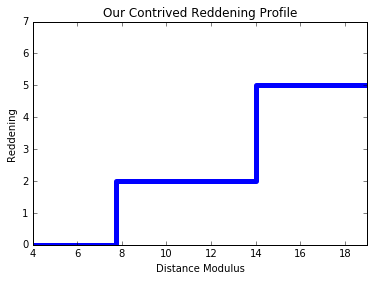

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

distance=np.array([4,7.75,7.75,14,14,19])
fake_reddening=np.array([0,0,2,2,5,5])

plt.plot(distance, fake_reddening,lw=5)
plt.xlabel(r'Distance Modulus')
plt.ylabel('Reddening')
plt.xlim(4,19)
plt.ylim(0,7)
plt.title("Our Contrived Reddening Profile")
plt.savefig("contrived_profile.pdf")

From the reddening profile, we can tell that this is a two cloud model towards a specific line of sight. We see that there are no clouds (and thus no reddening) between a distance modulus of 4 and 7.75. Then, we see that there's a cloud of dust at 7.75 which adds 2 magnitudes of reddening to our profile. Then we see that there's a second dust cloud at a distance modulus of 14 that adds 3 magnitudes of reddening to our profile, bringing our cumulative reddening at distance modulus 14 and beyond up to 5 magnitudes. 

So, now we need to produce some stellar posterior data (700x120 arrays of reddening vs. distance) to match our contrived profile. To do this, we are going to randomly sprinkle 50 stars along the line of sight. Since we are working with stellar posterior arrays, we are going to mentally convert everything from actual distance and reddening to distance and reddening bins in the stellar posterior arrays. Axis 0 of the array (the vertical axis) has a reddening range from 0-7 magnitudes, $\Delta_{reddening}$=0.01 magnitudes (total of 700 bins). Axis 0 of the array (the horizontal axis) has a distance modulus range from 4-19, so $\Delta_{distmod}$=0.125 (total of 120 bins). Our clouds in our contrived reddening profile correspond to distance modulus bins of 30 and 80, and reddening bins of 200 and 500. So now we randomly sprinkle 50 stars along the distance axis of the array, and then look up the reddening those stars should have based on our reddening profile. To produce the posterior for a single star we draw 5000 random samples from bivariate normal distribution with a mean centered at the randomly generated distance and the corresponding reddening value given by the reddening profile. We let the standard deviation of the bivariate normal distribution be 0.1 in both distance and reddenings, resulting in "puffy" clouds. We then use the samples to populate a 2D histogram, which is now our 700x120 stellar posterior array for a single star. We repeat this 49 more times for 49 more stars. This is how we code that: 

In [2]:
import pandas as pd

nstars=50

#randomly sprinkle 50 stars at 50 distances along the posterior horizontal axis (total bins=120)
randdist=np.random.randint(0,119,nstars)

#create our array to hold the corresponding reddening values taken from our contrived reddening profile 
red=np.empty(nstars)

for i in range(0,nstars):
    if randdist[i] < 30: #no clouds at a distance modulus bin <30, so reddening is zero
        red[i]=0
    
    if randdist[i] >= 30 and randdist[i] < 80: #one cloud between distance modulus bin of 30-80 (with reddening=2 mags)
        red[i]=200
    
    if randdist[i] >= 80: #two cloud between distance modulus bin of 80-120 (with cumulative reddening=5 mags)
        red[i]=500

#create array to hold our stellar posterior information 
post_array=np.empty((nstars,700,120))

#repeat 50 times for 50 stars
for i in range(0,nstars):
    mean=np.array([randdist[i],red[i]]) #mean of bivariate normal distribution set to random distance and corresponding reddening value
    cov=np.array([[1,0],[0,100]]) #standard deviations of ~0.1 in both reddening and distance modulus, converted to the number of bins that corresponds to on each axis
    data = np.random.multivariate_normal(mean, cov, 5000) #draw samples from that distribution
    df = pd.DataFrame(data, columns=["mu", "E"])
    H, yedges, xedges = np.histogram2d(df['E'],df['mu'],bins=[700,120], range=[[0, 700], [0, 120]]) #use those samples to create 2dhistogram, our stellar posterior!
    post_array[i,:,:]=H #store the posterior array for that star
    

We've plotted below what the posterior would look like if you stacked all the individual stellar posteriors on top of eachother (i.e. you summed along the depth axis). See that it looks similar to our contrived reddening profile, which is what we want! Note that the x and y axes correspond to the bin indices. When we integrate over distance modulus in our likelihood function, we only care about the reddening "ledges". We'll perform this integral from distance modulus=4 to distance modulus=19, over the entire length of the stellar posterior array for each individual star. 

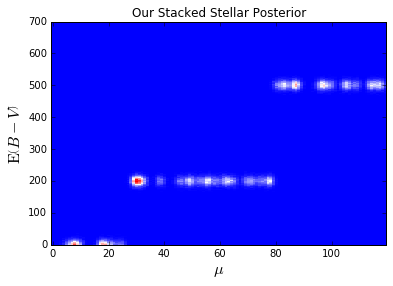

In [3]:
sumarray=np.sum(post_array, axis=0)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel(r'$\mu$', fontsize=16)
ax.set_ylabel(r'$\mathrm{E} \left( B - V \right)$', fontsize=16)
ax.imshow(sumarray, origin='lower',aspect='auto', cmap='bwr', interpolation='nearest')
ax.set_title("Our Stacked Stellar Posterior")
plt.savefig("simulated_stacked.pdf")

Now we are going to make some fake CO (carbon monoxide) data to go with our fake stellar posteriors. We have twelve CO intensity values for each star (for twelve CO velocity slices). The set of intensity values will be the same for each star, since they are all presumed to be along the same line of sight. Our fake reddening profile corresponds to two clouds (two CO emission features) at two different velocity slices. The first cloud has a reddening of 2 magnitudes, producing a cumulative reddening of 2 magnitudes. The second cloud has a reddening of 3 magnitudes, producing a cumulative reddening of 5 magnitudes (3 from itself and 2 from the other cloud). Assuming gas to dust coefficients to one, this means that we need to set one slice to CO intensity ("CO_I") value of 2 and the second slice to a CO intensity value of 3. All the other velocity slice intensities will be set to zero, because we are assuming there are only two clouds in all the slices. 

It doesn't really matter which two slices we put our clouds in (it only matters what distances and coefficients our parameter estimation problem gives us for the two slices). Thus, let's put the first cloud (CO_I=2) in velocity slice 7 and our second cloud (CO_I=3) in velocity slice 11.  So for a single star, our CO intensities for velocity slices 1-12 look like this: [0,0,0,0,0,0,2,0,0,0,0,3,0]. Now we have a stellar posterior array and a CO intensity array for every star. We write all this information out into a "simulated_data.h5" file:

In [4]:
import h5py

nslices=12

fwrite = h5py.File("/n/fink1/czucker/Data/simulated_data.h5", "w")
pdfs = fwrite.create_dataset("/stellar_pdfs", (nstars,700,120), dtype='f')
pdfs[:,:,:]=post_array #write our stellar posterior arrays calculated above to an hdf5 dataset

intensity=np.array([0,0,0,0,0,0,2,0,0,0,3,0]) #our identical CO array for every star

co_array=np.empty((nstars,12)) 

for i in range(0,nstars):
    co_array[i,:]=intensity

co_data = fwrite.create_dataset("/co_data", (nstars,nslices), dtype='f')
co_data[:,:]=co_array #write our co arrays to an hdf5 dataset

fwrite.close()

Based on our stellar posterior and CO data, we know what the values of d7, d11,c7, and c11 SHOULD be. D7 needs to be before D11, at a distance modulus of 7.75 and D11 needs to be at a distance modulus of 14. Both c7 and c11 should have values near 1, because that's what we assumed when created our reddening profile and assigning CO intensity values. Having those velocity slices correspond to those distances and coefficients will produce the highest value of the line integral along our reddening profile (see initial reddening profile figure), which is essentially our likelihood function. The distances and coefficients to the other ten slices cannot be constrained because their intensities are set to zero and thus contribute nothing to the reddening profile. 

Because our distributions are likely to be multi-modal, we are going to use Parallel-Tempering MCMC. To ensure that we aren't getting the "right" answer by chance, we are going to randomly set our walkers off within a reasonable distance range surrounding each cloud. For the d7 parameter, we are going to set our walker off somewhere between a distance modulus of 8 and 11, for our d11 parameter we are going to set our walker off somewhere between a distance modulus of 14 and 17. This way, we are sure not to initialize our walkers at an area of negative infinity probability, while still making it somewhat difficult for them the find their way back. Our final answers don't have to be exact (because we'd need a lot more simulated stars along the line of sight to make it perfect) but it does have to be close. Moreover, our distance estimates should get better if we increase the number of stars and should get worse if we increase the standard deviation of the bivariate Gaussian's we used to create the probability surfaces in our stellar posterior array. Let's see what happens...

# Results

Total number of stars used in analysis: 50
CPU times: user 1min 19s, sys: 35 ms, total: 1min 19s
Wall time: 1min 19s
Done
Our mean acceptance fraction for the coldest chain is 0.09
The autocorrelation times are...
[ 78.39429348   6.88571514  77.40453303  77.05617519  50.17486205
  73.84047265  38.51104131  82.18934354   8.53241019  82.68589279
  48.57510518  80.31183736  79.63775123  79.50018424  83.14249361
  83.31129922  85.15874813  72.66753762  15.59712018  77.4132397
  83.4485055   83.15191233  13.44427117  76.09735219]
d7 = 7.57 + 0.21 - 0.35
d11 = 14.10 + 0.22 - 0.22
c7 = 1.00 + 0.02 - 0.02
c11 = 1.00 + 0.02 - 0.02


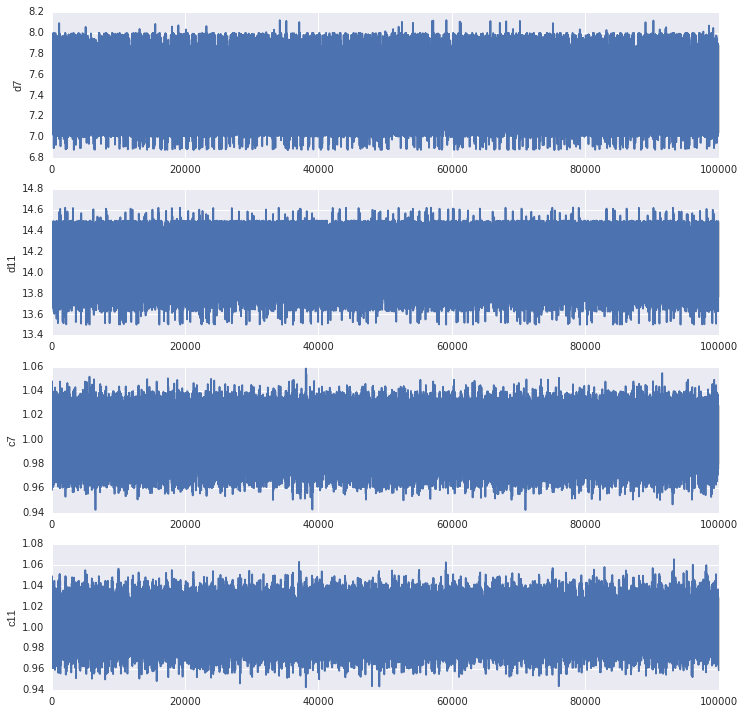

In [5]:
import emcee
from dustcurve import model
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from dustcurve import io
import warnings
import line_profiler
from dustcurve import plot_posterior
%matplotlib inline


#this code pulls snippets from the PHYS201 week 9 MCMC notebook written by Vinny Manohoran and the PHYS201 L9 solutions,
#written by Tom Dimiduk and Kevin Shain

#suppress obnoxious deprecation warning that doesn't affect output
warnings.filterwarnings("ignore", category=Warning, module="emcee")

# the model has 24 parameters; we'll use 100 walkers, 1000 steps each, at 5 different temps
nslices=12
ndim=24
nwalkers = 100
nsteps = 1000
ntemps=5

#fetch the required likelihood and prior arguments for PTSampler
ldata,pdata=io.fetch_args('simulated_data.h5',[4,19,0,10],1.0)

#set off the d7 and d11 parameters at random within a reasonable distance range surrounding the cloud
result=[np.random.randint(4,19) for i in range(nslices)]
result[6]=np.random.uniform(8,11)
result[10]=np.random.uniform(14,17)
result.extend(1.0 for i in range(nslices))

#set up the starting position array and add variance (up to 1 in distance modulus) to each walker 
starting_positions = [[result + 1e-1*np.random.randn(ndim) for i in range(nwalkers)] for j in range(ntemps)]

#set up the sampler object
sampler = emcee.PTSampler(ntemps, nwalkers, ndim, model.log_likelihood, model.log_prior, loglargs=(ldata), logpargs=[pdata])

#burn in, and save final positions for all parameters, which we'll then set off our walkers at for the "real" thing
post_burn_pos, prob, state = sampler.run_mcmc(starting_positions, 300)

#use the autocorrelation times from the burnin run to set the thinning integer for the "real" run. 
#autocorr=sampler.get_autocorr_time()
#autocorr_cold=autocorr[0,:]
#thin_int=int(np.mean(autocorr_cold))
sampler.reset()

# run the sampler. We use iPython's %time directive to tell us 
# how long it took (in a script, you would leave out "%time")
%time sampler.run_mcmc(post_burn_pos, nsteps)
print('Done')

#Extract the coldest [beta=1] temperature chain from the sampler object; discard first 100 samples from every walker
samples_cold = sampler.chain[0,:,:,:]
traces_cold = samples_cold.reshape(-1, ndim).T

#check out acceptance fraction:
print("Our mean acceptance fraction for the coldest chain is %.2f" % np.mean(sampler.acceptance_fraction[0]))

#check out the autocorrelation times:
print("The autocorrelation times are...")
autocorr=sampler.get_autocorr_time()
autocorr_cold=autocorr[0,:]
print(autocorr_cold)

#set up the figures to plot the hot chain
fig, (ax_d7, ax_d11, ax_c7, ax_c11) = plt.subplots(4, figsize=(10,10))
plt.tight_layout()
ax_d7.set(ylabel='d7')
ax_d11.set(ylabel='d11')
ax_c7.set(ylabel='c7')
ax_c11.set(ylabel='c11')

#plot the chains for the first ten walkers
sns.tsplot(traces_cold[6], ax=ax_d7)
sns.tsplot(traces_cold[10], ax=ax_d11)
sns.tsplot(traces_cold[18], ax=ax_c7)
sns.tsplot(traces_cold[22], ax=ax_c11)
    
parameter_samples = pd.DataFrame({'d7': traces_cold[6], 'd11': traces_cold[10], 'c7': traces_cold[18], 'c11':traces_cold[22]})

q = parameter_samples.quantile([0.16,0.50,0.84], axis=0)

#what values do we get?
print("d7 = {:.2f} + {:.2f} - {:.2f}".format(q['d7'][0.50], 
                                            q['d7'][0.84]-q['d7'][0.50],
                                            q['d7'][0.50]-q['d7'][0.16]))
print("d11 = {:.2f} + {:.2f} - {:.2f}".format(q['d11'][0.50], 
                                            q['d11'][0.84]-q['d11'][0.50],
                                            q['d11'][0.50]-q['d11'][0.16]))
print("c7 = {:.2f} + {:.2f} - {:.2f}".format(q['c7'][0.50], 
                                            q['c7'][0.84]-q['c7'][0.50],
                                            q['c7'][0.50]-q['c7'][0.16]))
print("c11 = {:.2f} + {:.2f} - {:.2f}".format(q['c11'][0.50], 
                                            q['c11'][0.84]-q['c11'][0.50],
                                            q['c11'][0.50]-q['c11'][0.16]))

Success! We see that we returned a value of for d7, d11, c7, and c11 are close to the true values given by 7.75, 14.00, 1.0, and 1.0. Thus, our PTSampler produced accurate results, well within the estimated uncertainties. 

Please note: if you're rerunning this notebook, these values will vary from trial to trial, and will depend on how many stars you simulate, along with the random distance generated along the sight for each star; every time you run the entire notebook and recreate the simulated_data.h5 file, you will get a slightly different reddening profile with stars at different distances along the $\mu$ axis of the posterior array. 

Finally, let's check out our reddening profile, using the 50th quantile samples returned by the MCMC chains. To see how well we did, let's overplot our reddening profile on top of our stacked stellar posterior surface. 

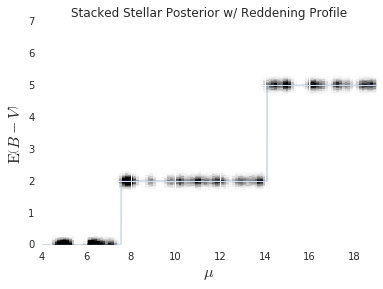

In [6]:
from dustcurve import pixclass

unique_co,indices,unique_post,ratio=ldata
pixObj=pixclass.PixStars('/n/fink1/czucker/Data/simulated_data.h5')
post_array=pixObj.get_p()

#find best fit values for each of the 24 parameters (12 d's and 12 c's)
theta=pd.DataFrame(traces_cold)
best=theta.quantile(.50, axis=1).values

#plot the reddening profile over the stacked, normalized stellar posterior surfaces    
plot_posterior.plot_posterior(post_array,np.linspace(4,19,120),np.linspace(0,7,700),best,ratio,unique_co,normcol=False)

In [11]:
from dustcurve import diagnostics
fnames='simulated_data.h5'
gr, chain_ensemble=diagnostics.run_chains(fnames,nwalkers=100,nsteps=1000,runs=5, ratio=1.0, simulated=True)
print("The GR diagnostic corresponding to d7,d11,c7, and c11 are...")
print(gr[6],gr[10],gr[18],gr[22])

Total number of stars used in analysis: 50
The GR diagnostic corresponding to d7,d11,c7, and c11 are...
0.980793237385 0.980235066648 0.980348569056 0.984104872609


Looks good! Let's move on to real data in tutorial.ipynb